### Imports

In [1]:
import pickle as pkl
import lxml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import importlib
import time
import traceback
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import imdb
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add,ZeroPadding1D, Layer
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from pylab import *



importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [2]:
tqdm.pandas()

In [3]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

### Helper Functions / Classes

In [4]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

### Data

In [29]:
chunk_size = 100

drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = chunk_size, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


print ("Reading data - chunk size : " + str(chunk_size) )
start = time.time()
drugbank = drugbank_reader.__next__()
end = time.time()
print ("Data read complete : " + str(end - start) + "s")



Reading data - chunk size : 100
Data read complete : 0.8530220985412598s


In [30]:
compressed_db = drugbank[['drug_id', 'gene_id']]

In [31]:
drug_dict = {}
gene_dict = {}
gene_id_code = {}
gene_id_encoding = {}

for drugbank in tqdm(drugbank_reader):
    
    compressed_db = drugbank[['drug_id', 'gene_id']]
    
    for i in range(len(compressed_db)):
        
        try:
            drug = compressed_db['drug_id'].values[i]
            gene = compressed_db['gene_id'].values[i]

            try:
                drug_dict[drug].add(gene)
            except: 
                drug_dict[drug] = set()
                drug_dict[drug].add(gene)

            try:
                gene_dict[gene].add(drug)
            except: 
                gene_dict[gene] = set()
                gene_dict[gene].add(drug)
                
             
            gene_id_code[gene] = drugbank[drugbank['gene_id'] == gene]['target_gene_encoded_len'].values[0]
            gene_id_encoding[gene] = drugbank[drugbank['gene_id'] == gene]['target_gene_encoded_padded'].values[0]
        
        except Exception as e: 
            print ("Exception : " + str(e))
            traceback.print_exc()
            continue

In [8]:
print ("Number Of Unique Drugs : " + str(len(drug_dict.keys())))
print ("Number Of Unique Genes : " + str(len(gene_dict.keys())))

Number Of Unique Drugs : 6215
Number Of Unique Genes : 3774


In [9]:
drug_to_gene_count = np.zeros((len(drug_dict.keys()), 2))
gene_to_drug_count = np.zeros((len(gene_dict.keys()), 2))

In [10]:
drug_keys = list(drug_dict.keys())
gene_keys = list(gene_dict.keys())

for d in range(len(drug_keys)):
    drug_to_gene_count[d][0] = d
    drug_to_gene_count[d][1] = len(drug_dict[drug_keys[d]])
drug_to_gene_count = pd.DataFrame(drug_to_gene_count)
drug_to_gene_count.columns = ['Drug Index', 'Number Of Genes']
    
for g in range(len(gene_keys)):
    gene_to_drug_count[g][0] = g
    gene_to_drug_count[g][1] = len(gene_dict[gene_keys[g]])
gene_to_drug_count = pd.DataFrame(gene_to_drug_count)
gene_to_drug_count.columns = ['Gene Index', 'Number Of Drugs']

In [11]:
percentile_list = [1, 25, 50, 75, 99]
print ("Percentile Split Of Drug -> Gene Interaction")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(drug_to_gene_count['Number Of Genes'], p)) + " Genes")
print ("") 
print ("Percentile Split Of Gene -> Drug Interaction")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(gene_to_drug_count['Number Of Drugs'], p)) + " Drugs")

Percentile Split Of Drug -> Gene Interaction
p1 : 1.0 Genes
p25 : 2.0 Genes
p50 : 6.0 Genes
p75 : 12.0 Genes
p99 : 160.0 Genes

Percentile Split Of Gene -> Drug Interaction
p1 : 1.0 Drugs
p25 : 3.0 Drugs
p50 : 8.0 Drugs
p75 : 19.0 Drugs
p99 : 290.39999999999964 Drugs


#### Build Lists Of Similar Genes

<b>Method 1 : </b>

Randomly Sample Genes To Build Lists Of Similar Genes

This will contain genes overlapping multiple drugs. We could run this multiple times and produce multiple
datasets to train the network on.

In [156]:
number_of_genes = len(gene_dict.keys())
list_of_genes = []
genes_considered = set()

for i in range(1000):
    
    # Select A Random Gene Not Yet Selected
    count = 0
    break_flag = 0
    while gene in genes_considered:
        gene = gene_keys[np.random.randint(number_of_genes)]
        count = count + 1 
        # All Genes Have Been Considered
        if count == len(gene_dict.keys()):
            break_flag = 1
            break
    
    if break_flag == 1: 
        break

    similar_genes = []
    
    # For Each Drug That Works On This Gene
    for drug in gene_dict[gene]:
        
        # Get Other Genes Affected By Drug
        for other_gene in drug_dict[drug]:
            
            # Check If This Gene Already Belongs To Another Group
            if other_gene not in genes_considered:
                genes_considered.add(other_gene)
                similar_genes.append(other_gene)
            else: 
                continue
    
    list_of_genes.append(similar_genes)         


gene_data_distribution = []
gene_train_set = []
min_threshold = 2
for l in list_of_genes: 
    if len(l) > 2:
        gene_train_set.append(l)
        gene_data_distribution.append(len(l))
        
print ("Number Of Similar Gene Lists With Length > " + str(min_threshold) + " : " + str(len(gene_train_set)))
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(gene_data_distribution, p)) + " Similar Genes")
print ("")    

Number Of Similar Gene Lists With Length > 2 : 81
p1 : 3.0 Similar Genes
p25 : 3.0 Similar Genes
p50 : 5.0 Similar Genes
p75 : 13.0 Similar Genes
p99 : 694.6000000000009 Similar Genes



<b>Method 2 : </b>

Pick out genes which are affected only by one drug. Then pick out other genes which are also affected 
by the same drug. 

In doing so, we ensure there is no overlap in similar genes across drugs.

In [12]:
list_of_genes = []
genes_considered = set()
single_drug_gene = []

# Find All Genes That Are Affected Only By ONE Drug 
for gene in gene_dict.keys():
    if len(gene_dict[gene]) == 1:
        single_drug_gene.append(gene)

# For Each Gene
for gene in single_drug_gene:
    
    # Skip Gene If It's Already Part Of A Similar Set
    if gene not in genes_considered: 
        
        genes_considered.add(gene)
        similar_genes = []

        # Find The Drug That Affects It
        drug = list(gene_dict[gene])[0]


        # Find Other Genes This Drug Affects And Add It To Similar Genes
        for other_gene in drug_dict[drug]:
            similar_genes.append(other_gene)
            genes_considered.add(other_gene)

        list_of_genes.append(similar_genes)
    
    else: 
        continue

gene_data_distribution = []
gene_train_set = []
min_threshold = 2
for l in list_of_genes: 
    if len(l) > min_threshold:
        gene_train_set.append(l)
        gene_data_distribution.append(len(l))
        
print ("Number Of Similar Gene Lists With Length > " + str(min_threshold) + " : " + str(len(gene_train_set)))
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(gene_data_distribution, p)) + " Similar Genes")
print ("")    

Number Of Similar Gene Lists With Length > 2 : 112
p1 : 3.0 Similar Genes
p25 : 7.0 Similar Genes
p50 : 14.0 Similar Genes
p75 : 38.5 Similar Genes
p99 : 164.23 Similar Genes



In [57]:
deviation_list = []
for gene_l in gene_train_set:
    length_list = []
    for gene in gene_l:
        length_list.append(gene_id_code[gene])
    deviation_list.append(np.std(length_list))

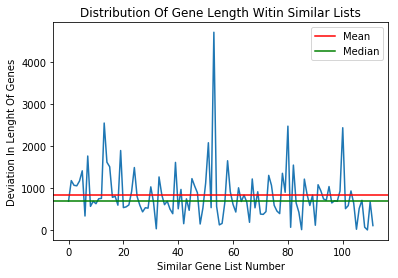

In [65]:
plt.plot(deviation_list)
plt.axhline(np.mean(deviation_list), color = 'r', label = 'Mean')
plt.axhline(np.median(deviation_list), color = 'g', label = 'Median')
plt.xlabel('Similar Gene List Number')
plt.ylabel('Deviation In Lenght Of Genes')
plt.title("Distribution Of Gene Length Witin Similar Lists")
plt.legend()
plt.show()

##### Construct Training Sets 
Select Three Genes - An Anchor Gene, a Positive Gene and a Negative Gene

In [112]:
training_data_start = time.time()
gene_triplet_sanity_check = []
gene_triplet_training_data = []

for similar_list in gene_train_set: 
    
    anchor_gene = similar_list[0]
    for gene in range(1, len(similar_list)):
        positive_gene = similar_list[gene]
        
        random_list = gene_train_set[np.random.randint(0, len(gene_train_set))]
        while similar_list == random_list:
            random_list = gene_train_set[np.random.randint(0, len(gene_train_set))]
            
        negative_gene = np.random.choice(random_list)
        
        anchor_encoding = np.expand_dims(gene_id_encoding[anchor_gene], axis = 0).astype('float64')
        positive_encoding = np.expand_dims(gene_id_encoding[positive_gene], axis = 0).astype('float64')
        negative_encoding = np.expand_dims(gene_id_encoding[negative_gene], axis = 0).astype('float64')
        
        anchor_encoding = np.expand_dims(anchor_encoding, axis = -1)
        positive_encoding = np.expand_dims(positive_encoding, axis = -1)
        negative_encoding = np.expand_dims(negative_encoding, axis = -1)
        
        gene_triplet_training_data.append([anchor_encoding, positive_encoding, negative_encoding])
        gene_triplet_sanity_check.append([anchor_gene, positive_gene, negative_gene])
            
training_data_end = time.time()
print ("Time To Build Training Data : " + str(training_data_end - training_data_start))

Time To Build Training Data : 144.16918921470642


#### Build List Of Similar Drugs

Pick out drugs which work only on one gene. Then pick out other drugs which also work on the same gene.

In doing so, we ensure there is no overlap in similar drugs across genes.

In [162]:
list_of_drugs = []
drugs_considered = set()
single_gene_drug = []

# Find All Drugs That Work Only On ONE Gene
for drug in drug_dict.keys():
    if len(drug_dict[drug]) == 1:
        single_gene_drug.append(drug)
        
# For Each Drug
for drug in single_gene_drug:
    
    # Skip Drug If It's Already Part Of A Similar Set
    if drug not in drugs_considered: 
        
        drugs_considered.add(drug)
        similar_drugs = []

        # Find The Gene That The Drug Works On
        gene = list(drug_dict[drug])[0]


        # Find Other Drugs That Work On This Gene
        for other_drug in gene_dict[gene]:
            similar_drugs.append(other_drug)
            drugs_considered.add(other_drug)

        list_of_drugs.append(similar_drugs)
    
    else: 
        continue
        
drug_data_distribution = []
drug_train_set = []
min_threshold = 2
for l in list_of_drugs: 
    if len(l) > min_threshold:
        drug_train_set.append(l)
        drug_data_distribution.append(len(l))
        
print ("Number Of Similar Drug Lists With Lenght > " + str(min_threshold) + " : " + str(len(drug_train_set)))
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(drug_data_distribution, p)) + " Similar Drugs")
print ("")   

Number Of Similar Drug Lists With Lenght > 2 : 291
p1 : 3.0 Similar Drugs
p25 : 7.0 Similar Drugs
p50 : 14.0 Similar Drugs
p75 : 27.5 Similar Drugs
p99 : 153.30000000000007 Similar Drugs



### Siamese Network

#### Define Convolutional Model 

In [98]:
def conv_network(input_shape = (21222, 1), output_shape = 256):
    
    X_input = Input(input_shape, name = "Input_Layer")
    
    # Convolution Block 1
    X = Conv1D(filters = 64, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB1_Conv_1")(X_input)
    X = Conv1D(filters = 64, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB1_Conv_2")(X)
    X = BatchNormalization(name = "CB1_BN_1")(X)
    
    # Convolution Block 2
    X = Conv1D(filters = 128, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB2_Conv_1")(X)
    X = Conv1D(filters = 128, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB2_Conv_2")(X)
    X = BatchNormalization(name = "CB2_BN_1")(X)
    X = AveragePooling1D(name = "CB2_AvgPool_1")(X)
    # Test Drop Out
    # X = Dropout(0.4)(X)

    # Convolution Block 3
    X = Conv1D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB3_Conv_1")(X)
    X = Conv1D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB3_Conv_2")(X)
    X = Conv1D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB3_Conv_3")(X)
    X = BatchNormalization(name = "CB3_BN_1")(X)
    # Test Drop Out
    # X = Dropout(0.5)(X)
    
    # Flatten
    X = Flatten(name = "Flatten_Layer")(X)
    X = Dense(512, activation = 'relu', kernel_initializer = 'he_uniform', name = "Dense_Layer_1")(X)
    X = Dense(output_shape, activation = None, name = "Final_Dense_Layer")(X)
    
    return Model(inputs = X_input, outputs = X)

In [99]:
conv_model = conv_network()

#### Define Triplet Loss

In [117]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis = 0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

#### Overall Model

In [122]:
def siamese_model(input_shape, conv_model, margin = 0.3):
    
    # Three Input Genes
    anchor_gene = Input(input_shape, name = "Anchor_Gene")
    positive_gene = Input(input_shape, name = "Positive_Gene")
    negative_gene = Input(input_shape, name = "Negative_Gene") 
    
    # Generate Encodings 
    encoded_a = conv_model(anchor_gene)
    encoded_p = conv_model(positive_gene)
    encoded_n = conv_model(negative_gene)
    
    # Compute Triplet Loss
    loss_layer = TripletLossLayer(alpha = margin, name = 'Triplet_Loss_Layer')([encoded_a, encoded_p, encoded_n])
    
    model = Model(inputs = [anchor_gene, positive_gene, negative_gene], outputs = loss_layer)
    
    return model

In [123]:
siamese_network = siamese_model(input_shape = (21222, 1), conv_model = conv_model)

In [124]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     (None, 21222, 1)          0         
_________________________________________________________________
CB1_Conv_1 (Conv1D)          (None, 10610, 64)         320       
_________________________________________________________________
CB1_Conv_2 (Conv1D)          (None, 5304, 64)          16448     
_________________________________________________________________
CB1_BN_1 (BatchNormalization (None, 5304, 64)          256       
_________________________________________________________________
CB2_Conv_1 (Conv1D)          (None, 2651, 128)         32896     
_________________________________________________________________
CB2_Conv_2 (Conv1D)          (None, 1324, 128)         65664     
_________________________________________________________________
CB2_BN_1 (BatchNormalization (None, 1324, 128)         512       
__________

In [125]:
siamese_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Gene (InputLayer)        (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
Positive_Gene (InputLayer)      (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
Negative_Gene (InputLayer)      (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 256)          11521920    Anchor_Gene[0][0]                
                                                                 Positive_Gene[0][0]              
          

In [126]:
optimizer = Adam(lr = 0.00001)
siamese_network.compile(loss = None, optimizer = optimizer)

#### Train

In [ ]:
siamese_network 

In [127]:
epoch = 20
print_frequency = 100

train_start = time.time()

for e in range(epoch):
    
    epoch_start = time.time()
    for data in range(len(gene_triplet_training_data)):
        
        triplets = gene_triplet_training_data[data]
        loss = siamese_network.train_on_batch(triplets, None)
        
        if data % print_frequency == 0:
            print ("Epoch : " + str(e) + " | Iteration : " + str(data) + " | Loss : " + str(loss))
    epoch_end = time.time()
    print ("Epoch Time : " + str(epoch_end - epoch_start))
    
train_end = time.time()
print ("Total Time To Train : " + str(train_end - train_start)) 

Epoch : 0 | Iteration : 0 | Loss : 0.0
Epoch : 0 | Iteration : 100 | Loss : 0.0
Epoch : 0 | Iteration : 200 | Loss : 4.2474985
Epoch : 0 | Iteration : 300 | Loss : 0.0
Epoch : 0 | Iteration : 400 | Loss : 0.0
Epoch : 0 | Iteration : 500 | Loss : 0.0
Epoch : 0 | Iteration : 600 | Loss : 1.1044204
Epoch : 0 | Iteration : 700 | Loss : 0.0
Epoch : 0 | Iteration : 800 | Loss : 0.0
Epoch : 0 | Iteration : 900 | Loss : 0.0
Epoch : 0 | Iteration : 1000 | Loss : 0.0
Epoch : 0 | Iteration : 1100 | Loss : 0.0
Epoch : 0 | Iteration : 1200 | Loss : 0.0
Epoch : 0 | Iteration : 1300 | Loss : 1.079006
Epoch : 0 | Iteration : 1400 | Loss : 0.0
Epoch : 0 | Iteration : 1500 | Loss : 0.0
Epoch : 0 | Iteration : 1600 | Loss : 0.0
Epoch : 0 | Iteration : 1700 | Loss : 0.0
Epoch : 0 | Iteration : 1800 | Loss : 11.574567
Epoch : 0 | Iteration : 1900 | Loss : 0.081149876
Epoch : 0 | Iteration : 2000 | Loss : 1.1483519
Epoch : 0 | Iteration : 2100 | Loss : 0.0
Epoch : 0 | Iteration : 2200 | Loss : 3.3311236
Epo

KeyboardInterrupt: 